# ISA

This notebook provides wrapper functions for calling the [ISA (Iterative Subtractive Alignment) algorithm](https://archives.ismir.net/ismir2021/paper/000101.pdf).  Running this algorithm requires installing some other software, which is described below.  This notebook implements the `offline_processing()` and `online_processing()` functions, which will be imported and run in `02_RunExperiment.ipynb`.

## Offline Processing

The offline processing is the same as in the simple offline DTW system.  In the offline processing stage, three things are computed and stored in the `cache/` folder:
- chroma features for the orchestra recording
- chroma features for the full mix recording
- predicted DTW alignment between the orchestra and full mix recordings



In [1]:
import numpy as np
import pandas as pd
import import_ipynb
import System_OfflineDTW
import system_utils
import align_tools
import sonify_tools
import os
import os.path
import subprocess
import librosa as lb
import vamp
from shutil import which
from hmc_mir.align import isa
import matplotlib.pyplot as plt

importing Jupyter notebook from System_OfflineDTW.ipynb
importing Jupyter notebook from align_tools.ipynb


In [2]:
def split_into_five_second_segments(piano_cqt):
    n = piano_cqt.shape[1]
    return [[i, min(i+215, n)] for i in range(0, n, 215)]

In [3]:
def offline_processing(scenario_dir, cache_dir, hop_length, alg='cqt'):
    '''
    Carries out the same offline processing steps as the simple offline DTW system.
    
    Args:
        scenario_dir: The scenario directory to process
        cache_dir: The location of the cache directory
        hop_length: The hop length in samples used when computing chroma features
        alg: The chroma feature algorithm to use. Must be one of 'cqt', 'bcqt', or 'chroma'.
    
    This function will store the computed chroma features and estimated alignment in the cache folder.
    '''
    # setup
    system_utils.verify_scenario_dir(scenario_dir)
    if os.path.exists(cache_dir):
        # print(f'{cache_dir} has already been processed.  Skipping.')
        pass
    else:
        # setup
        os.makedirs(cache_dir)



        orch_start_sec, orch_end_sec = system_utils.get_orchestra_start_end_times(scenario_dir)

        o_file = f'{scenario_dir}/o.wav'
        y_o, sr = lb.core.load(o_file)
        y_o = y_o[int(orch_start_sec*sr):int(orch_end_sec*sr)]
        F_o = isa.calculate_cqt(y_o, sr, hop_length)
        segments_o = split_into_five_second_segments(F_o)

        po_file = f'{scenario_dir}/po.wav'
        y_po, sr = lb.core.load(po_file)
        F_po = isa.calculate_cqt(y_po, sr, hop_length)

        if alg == 'cqt':
            F_po_subtracted, wp = isa.isa_cqt(F_o, F_po, segments_o)
        elif alg == 'bcqt':
            F_po_subtracted, wp = isa.isa_bcqt(F_o, F_po, segments_o)
        elif alg == 'chroma':
            F_po_subtracted, wp = isa.isa_chroma(F_o, F_po, segments_o)
        else:
            raise ValueError(f'alg must be one of cqt, bcqt, or chroma.  Received {alg}')

        orch_start_frm = int(np.round(orch_start_sec * sr / hop_length))
        orch_end_frm = int(np.round(orch_end_sec * sr / hop_length)) + 1
        wp[0,:] = wp[0,:] + orch_start_frm # account for offset

        np.save(f'{cache_dir}/po_subtracted_cqt.npy', F_po_subtracted)
        np.save(f'{cache_dir}/o_po_align.npy', wp)

    return

In [4]:
def verify_cache_dir(indir):
    '''
    Verifies that the specified cache directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/po_subtracted_cqt.npy'), f'missing {indir}/po_subtracted_cqt.npy'
    assert os.path.exists(f'{indir}/o_po_align.npy'), f'missing {indir}/o_po_align.npy'

## Online Processing

In the online processing stage, we do two things:
1. compute an online alignment between the piano and full mix recordings using MATCH,
2. use the predicted alignment to infer the alignment between the piano and orchestra recordings

Note that step 1 is completed before we begin step 2.  This implementation is thus not a valid online system, but its performance nonetheless can tell us how well an online system would perform.

### Software Installation

Using the MATCH algorithm requires a few pieces of software to be installed:
- [Sonic Annotator](https://vamp-plugins.org/sonic-annotator/), a program for command-line processing of audio files
- [the MATCH Vamp plugin](https://code.soundsoftware.ac.uk/projects/match-vamp/), an implementation of the MATCH algorithm which can be used in tandem with Sonic Annotator
- the SoX command line audio utility tool

Below, we will assume that the `sonic-annotator` and `sox` binaries can be called from command line, and that the MATCH Vamp plugin has been installed.  See [here](https://vamp-plugins.org/download.html#install) for instructions on how to install Vamp plugins.

### Wrapper Implementation

In [5]:
def online_processing(scenario_dir, out_dir, cache_dir, hop_length, alg='cqt'):
    '''
    Carries out `online' processing using the ISA algorithm.
    
    Args:
        scenario_dir: The scenario directory to process
        out_dir: The directory to put results, intermediate files, and logging info
        cache_dir: The cache directory
        hop_length: The hop length in samples used when computing cqt features
        alg: The chroma feature algorithm to use. Must be one of 'cqt', 'bcqt', or 'chroma'.

    This function will compute and save the predicted alignment in the output directory in a file hyp.npy
    '''
    
    # verify & setup
    system_utils.verify_scenario_dir(scenario_dir)
    verify_cache_dir(cache_dir)
    assert not os.path.exists(out_dir), f'Output directory {out_dir} already exists.'
    os.makedirs(out_dir)

    orch_start_sec, orch_end_sec = system_utils.get_orchestra_query_boundaries(scenario_dir)

    # compute features
    p_file = f'{scenario_dir}/p.wav'
    y, sr = lb.core.load(p_file)
    hop_sec = hop_length / sr

    wp_BC = np.flipud(np.load(f'{cache_dir}/o_po_align.npy'))
    wp_BC = np.hstack((np.array([0,0]).reshape((2,-1)), wp_BC)) # prepend (0,0) to handle edge cases properly
    fullmix_start_frm = int(np.interp(orch_start_sec*hop_sec, wp_BC[1,:], wp_BC[0,:])) # estimate end time of query in full mix

    F_p = isa.calculate_cqt(y, sr, hop_length)  # piano features
    segments_p = split_into_five_second_segments(F_p)
    F_po_subtracted = np.load(f'{cache_dir}/po_subtracted_cqt.npy') # full mix features
    F_po_subtracted = F_po_subtracted[:,fullmix_start_frm:] # truncate to start of query

    if alg == 'cqt':
        F_po_empty, wp_AB = isa.isa_cqt(F_p, F_po_subtracted, segments_p)
    elif alg == 'bcqt':
        F_po_empty, wp_AB = isa.isa_bcqt(F_p, F_po_subtracted, segments_p)
    elif alg == 'chroma':
        F_po_empty, wp_AB = isa.isa_chroma(F_p, F_po_subtracted, segments_p)
    else:
        raise ValueError(f'alg must be one of cqt, bcqt, or chroma.  Received {alg}')

    wp_AB[1,:] = wp_AB[1,:] + fullmix_start_frm # account for offset
    
    # infer piano-orchestra alignment
    wp_AC = align_tools.infer_alignment(wp_AB, wp_BC, frames=True)
    
    np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)
    np.save(f'{out_dir}/p_po_align.npy', wp_AB)
    
    return

In [6]:
def verify_hyp_dir(indir):
    '''
    Verifies that the specified scenario hypothesis directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/hyp.npy'), f'{indir} is missing the required files, please re run the online processing'

# Example

Here is an example of how to call the offline and online processing functions on a scenario directory.

In [54]:
scenario_dir = 'scenarios/s2'
out_dir = 'experiments/ISA_CQT/s2'
cache_dir = 'experiments/ISA_CQT/cache/rach2_mov1_O1_PO1'
hop_length = 512

In [55]:
orch_start_sec, orch_end_sec = system_utils.get_orchestra_start_end_times(scenario_dir)

o_file = f'{scenario_dir}/o.wav'
y_o, sr = lb.core.load(o_file)
y_o = y_o[int(orch_start_sec*sr):int(orch_end_sec*sr)]
F_o = isa.calculate_cqt(y_o, sr, hop_length)
segments_o = split_into_five_second_segments(F_o)

po_file = f'{scenario_dir}/po.wav'
y_po, sr = lb.core.load(po_file)
F_po = isa.calculate_cqt(y_po, sr, hop_length)

F_po_subtracted, wp = isa.isa_chroma(F_o, F_po, segments_o)

orch_start_frm = int(np.round(orch_start_sec * sr / hop_length))
orch_end_frm = int(np.round(orch_end_sec * sr / hop_length + 1))
wp[0,:] = wp[0,:] + orch_start_frm  # account for offset

np.save(f'{cache_dir}/po_subtracted_cqt.npy', F_po_subtracted)
np.save(f'{cache_dir}/o_po_align.npy', wp)

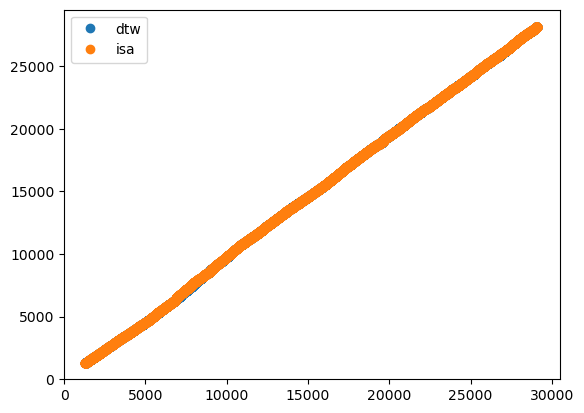

In [56]:
dtw_wp = np.load('experiments/offlineDTW/cache/rach2_mov1_O1_PO1/o_po_align.npy')
# dtw_wp = np.load('experiments/offlineDTW/s2/p_po_align.npy')

wp_scaled = wp

plt.plot(dtw_wp[0], dtw_wp[1], 'o', label="dtw")
plt.plot(wp_scaled[0], wp_scaled[1], 'o', label="isa")
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend()

In [57]:
p_file = f'{scenario_dir}/p.wav'
y, sr = lb.core.load(p_file)

hop_sec = hop_length / sr
orch_start_sec, _ = system_utils.get_orchestra_query_boundaries(scenario_dir)
orch_start_frm = orch_start_sec / hop_sec  # keep max precision, don't round

# infer the start time of the query in the full mix recording (estimated)
wp_BC = np.flipud(np.load(f'{cache_dir}/o_po_align.npy'))
wp_BC = np.hstack((np.array([0,0]).reshape((2,-1)), wp_BC)) # prepend (0,0) to handle edge cases properly
fullmix_start_frm = int(np.round(np.interp(orch_start_frm, wp_BC[1,:], wp_BC[0,:])))

F_p = isa.calculate_cqt(y, sr, hop_length)  # piano features
F_po = np.load(f'{cache_dir}/po_subtracted_cqt.npy') # full mix features
F_po = F_po[:,fullmix_start_frm:] # truncate to start of query
segments_p = split_into_five_second_segments(F_p)

F_po_subtracted, wp_AB = isa.isa_chroma(F_p, F_po, segments_p)

In [58]:
# wp_AB = np.load('experiments/offlineDTW/s2/p_po_align.npy')

In [59]:
# infer piano-orchestra alignment
wp_AB_ = wp_AB.copy()
wp_AB_[1,:] = wp_AB_[1,:] + fullmix_start_frm
wp_AC = align_tools.infer_alignment(wp_AB_, wp_BC, frames=True)
np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)

In [52]:
system_utils.get_orchestra_query_boundaries(scenario_dir)

(154.8364626, 298.395283447)

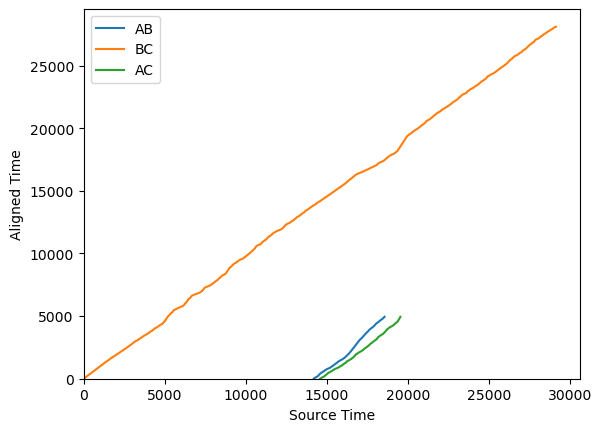

In [53]:
import matplotlib.pyplot as plt

alignment1 = wp_AB_
alignment2 = wp_BC
alignment3 = wp_AC

plt.plot(alignment1[1], alignment1[0], label='AB')
plt.plot(alignment2[1], alignment2[0], label='BC')
plt.plot(alignment3[1], alignment3[0], label='AC')
plt.xlabel('Source Time')
plt.ylabel('Aligned Time')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend()
plt.show()